In [13]:
# make the dataset again 

import pandas as pd

df = pd.read_csv("all_data_2.csv")
df = df.drop(columns=["Unnamed: 0"])
df['Price'] = df['Price'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
df.head()

,tee,oxford,bomber,ncaa,vest,3-in-1,collared,packable,seersucker,playoff,...,sheer,7/8-length,shirt,flouncy,v-neck,color-blocked,pants,cheeky,yoga,Price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,70.0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,160.0


In [14]:
# read in data
x_train = pd.read_csv("x_train.csv")
x_test = pd.read_csv("x_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# we want the same datasets that were used in the lasso model 

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
rfr = RandomForestRegressor(random_state=16)
rfr.fit(x_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=16)

In [17]:
y_pred = rfr.predict(x_test)

In [18]:
y_test = y_test.values.flatten()
y_test.shape

(2479,)

In [19]:
# metrics
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(y_test, y_pred)
corr, _ = pearsonr(y_test, y_pred)
print("Pearson correlation coefficient:", corr)
print("Mean squared error: ", mse)

Pearson correlation coefficient: 0.9497381019126114
Mean squared error:  275.2122950886171


Wow, random forest performed WAY better than lasso! That goes to show that pricing models aren't linear (who would have thought?? kidding of course.) Now let's see what the shap values have to say about each feature! 

In [20]:
import shap
import numpy as np 

x = df.iloc[:, :-1]
y = df.iloc[:, -1]

explainer = shap.Explainer(rfr)

In [22]:
shap_values = explainer.shap_values(x_train, check_additivity=False)

import pickle

# Save SHAP values to a file
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)


In [12]:
x.shape


(9916, 468)

We use x, the entire feature matrix, instead of x_test because we want to see the insights on the data that was used for prediction. We are less concerned with generalizability and how the model reacts to unseen data. 

Shap values video: 
https://www.youtube.com/watch?v=L8_sVRhBDLU

And remember: whenever you use pickle dump and load, make sure to use the same x matrix that you have been using. it is just the all_data_2 df with a few tweaks, as shown above. 

note that x-train and test are always the same because we just imported them. 

In [23]:
# RUN THIS WHEN U WANT TO LOAD UP SHAP VALUES AGAIN 
import pickle
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)


# now you should have your shap_values object back. 

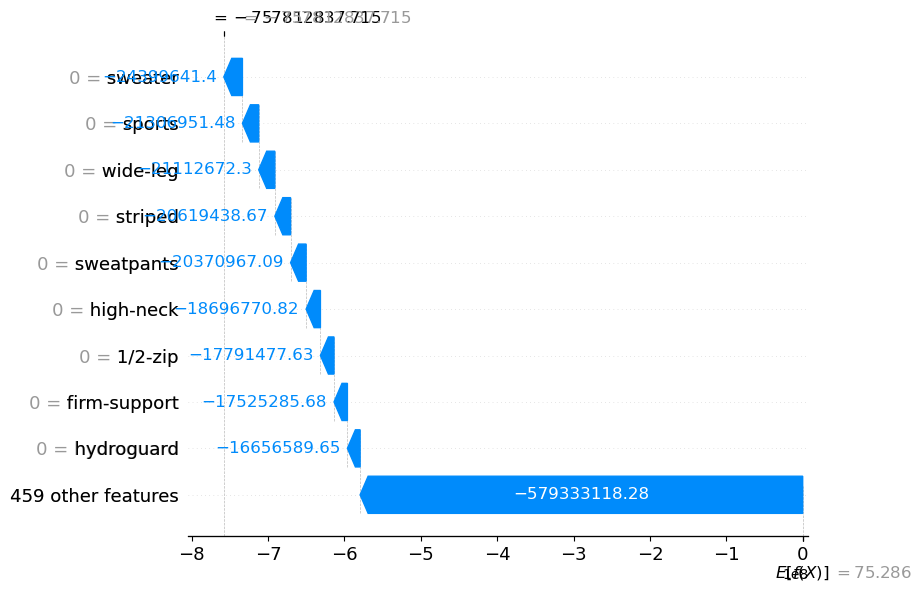

In [29]:
shap_values_2 = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=x_train, feature_names=x_train.columns)
shap.plots.waterfall(shap_values_2[0])

In [35]:
import pandas as pd 
mean_shap_values = pd.DataFrame({
    'Feature': x_train.columns, 
    'Mean SHAP Value': np.mean(shap_values_2.values, axis=0)
})

mean_shap_values = mean_shap_values.sort_values(by='Mean SHAP Value', ascending=False)
mean_shap_values.head()

,Feature,Mean SHAP Value
108,leggings,1.421079e+06
158,terry,3.935211e+05
62,short-sleeve,2.629788e+05
170,polo,2.590452e+05
251,camo,2.502809e+05


In [36]:
mean_shap_values.tail()

,Feature,Mean SHAP Value
422,velour,-4.947534e+06
426,winterized,-5.089985e+06
72,bralette,-5.336964e+06
405,over-oversized,-5.755059e+06
321,cropped,-6.177043e+06


In [41]:
mean_shap_values['Absolute value'] = mean_shap_values['Mean SHAP Value'].abs()
sub_df = mean_shap_values[mean_shap_values['Absolute value'] > 10]

,Feature,Mean SHAP Value,Absolute value
108,leggings,1.421079e+06,1.421079e+06
158,terry,3.935211e+05,3.935211e+05
62,short-sleeve,2.629788e+05,2.629788e+05
170,polo,2.590452e+05,2.590452e+05
251,camo,2.502809e+05,2.502809e+05


In [47]:
sub_df = mean_shap_values[mean_shap_values['Absolute value'] > 1000000]
sub_df.shape

(58, 3)

In [60]:
sub_df = sub_df.sort_values(by='Mean SHAP Value', ascending=False)
print(sub_df)
#sub_df.to_csv("shap_values_top_58.csv")

            Feature  Mean SHAP Value  Absolute value
108        leggings     1.421079e+06    1.421079e+06
4              vest    -1.009886e+06    1.009886e+06
146          footie    -1.081858e+06    1.081858e+06
290            crew    -1.159193e+06    1.159193e+06
415        bodysuit    -1.183048e+06    1.183048e+06
267           dress    -1.183292e+06    1.183292e+06
36            scoop    -1.224520e+06    1.224520e+06
48          1-piece    -1.227545e+06    1.227545e+06
63           poncho    -1.366740e+06    1.366740e+06
349             bra    -1.440615e+06    1.440615e+06
315            swim    -1.449317e+06    1.449317e+06
246             mid    -1.456152e+06    1.456152e+06
425     performance    -1.474963e+06    1.474963e+06
421            size    -1.600059e+06    1.600059e+06
13        windshirt    -1.604958e+06    1.604958e+06
419            nwsl    -1.638301e+06    1.638301e+06
429        full-zip    -1.732503e+06    1.732503e+06
148       high-neck    -1.736507e+06    1.7365

In [55]:
mean_shap_values.to_csv("mean_shap_values.csv")
df2 = mean_shap_values

In [56]:
df2['Normalized Mean SHAP Value'] = df2['Mean SHAP Value'] / (df2['Mean SHAP Value'].max() - df2['Mean SHAP Value'].min())


In [57]:
df2.to_csv("mean_shape_values_with_normalization.csv")